In [112]:
#Import delle librerie
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2

#Funzione di fit gaussiana
def func(x, A, mu, sigma, B, mu2, sigma2):
    return A * norm.pdf(x, mu, sigma) + B * norm.pdf(x, mu2, sigma2)

In [94]:
#Funzioni SNIP

def frequency_converter(counts, time_signal=577, frequency_back=frequency_back, time_background=9218, counts_back=counts_back):
    frequency = counts/time_signal
    counts_back = counts_back [:len(frequency)]
    frequency_ = frequency - frequency_back[:len(frequency)]
    for i in range(len(frequency_)):
        if frequency_[i] < 0:
            frequency_[i] = 0
    error = np.sqrt(counts/time_signal**2 + counts_back/time_background**2)
    return frequency_, error

def SNIP_algorithm(spectrum, iterations=40):
    spectrum_log = np.log(np.log(np.sqrt(spectrum + 1) + 1) + 1)
    n_added = iterations
    begin_list = np.ones(n_added) * spectrum_log[0]
    end_list = np.ones(n_added) * spectrum_log[-1]
    spectrum_log = np.concatenate((begin_list, spectrum_log, end_list))
    for k in range(1, iterations+1, 1):
        for i in range(len(spectrum_log[n_added:-n_added])):
            spectrum_log[i] = np.minimum(spectrum_log[i], 0.5 * (spectrum_log[i+k] + spectrum_log[i-k]))
    return (np.exp(np.exp(spectrum_log[n_added:-n_added])-1)-1)**2-1

def multi_SNIP_algorithm(spectrum, channel, iterations=40, delta_n=5):
    spectra = []
    for i in range(iterations-delta_n, iterations+delta_n, 1):
        spectra.append(SNIP_algorithm(spectrum, i))
        if i == iterations-delta_n:
            plt.plot(channel, spectra[0], label='SNIP1', alpha=0.4)
        if i == iterations:
            plt.plot(channel, spectra[delta_n-1], label='SNIP2', alpha=0.4)
        if i == iterations+delta_n-1:
            plt.plot(channel, spectra[2*delta_n-1], label='SNIP3', alpha=0.4)
    
    mean_spectrum = np.mean(spectra, axis=0)
    err_spectrum = np.std(spectra, axis=0)/np.sqrt(len(spectra))
    plt.plot(channel, mean_spectrum, label='Mean SNIP')
    plt.errorbar(channel, mean_spectrum, yerr=err_spectrum, fmt='.', alpha=0.01)
    plt.plot(channel, spectrum, label='Spectrum', alpha=0.8)
    plt.legend()
    plt.grid()
    plt.xlabel('Channel')
    plt.ylabel('Frequency')
    plt.show()
    return mean_spectrum, err_spectrum

In [95]:
#Caricamento ed elaborazione fondo

rumore = pd.read_csv(r'C:\Users\civig\Desktop\SiPM\Cristalli\Probabilities\Fondi\BGO-9218.CSV', sep=';')

channel_back = np.array(rumore['Channel'])
counts_back = np.array(rumore['Counts'])
time_back = 9218 #s
frequency_back = counts_back/time_back

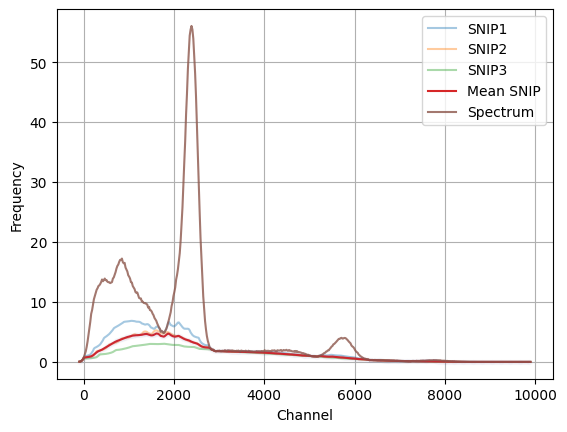

In [121]:
#Caricamento ed elaborazione spettro sodio

segnale_0cm = pd.read_csv(r'C:\Users\civig\Desktop\SiPM\Cristalli\Probabilities\new-na-0cm.CSV', sep=';', engine='python')
channel_0 = np.array(segnale_0cm['Channel'][:500])
counts_0 = np.array(segnale_0cm['BGO'][:500])

# calculating frequency and removing background noise via SNIP
frequency_0 = frequency_converter(counts_0, time_signal=577)
background_0, err_background_0 = multi_SNIP_algorithm(frequency_0[0], channel_0, iterations=15, delta_n=4)

frequency_0 = (frequency_0[0] - background_0, np.sqrt(frequency_0[1]**2+err_background_0**2))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 143.4 (χ²/ndof = 3.0)      │              Nfcn = 419              │
│ EDM = 7.21e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  16.6e3   │   0.5e3   │            │            │         │         │       │
│ 1 │ mu     │ 2.4011e3  │ 0.0027e3  │            │            │         │         │       │
│ 2 │ sigma  │   130.3   │    0.9    │            │            │         │         │       │
│ 3 │ B      │   3.5e3   │   0.5e3   │            │            │         │         │       │
│ 4 │ mu2    │  2.137e3  │  0.023e3  │            │            │         │         │       │
│ 5 │ sigma2 │    158    │    11     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma        B      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │ 2.34e+05 -1.271e3    417.5  -0.24e6  -10.9e3  -5.05e3 │
│     mu │ -1.271e3      7.1     -2.4  1.288e3       59       27 │
│  sigma │    417.5     -2.4    0.867   -421.0    -19.2     -8.3 │
│      B │  -0.24e6  1.288e3   -421.0 2.43e+05   11.0e3   5.18e3 │
│    mu2 │  -10.9e3       59    -19.2   11.0e3      515   0.24e3 │
│ sigma2 │  -5.05e3       27     -8.3   5.18e3   0.24e3      120 │
└────────┴───────────────────────────────────────────────────────┘

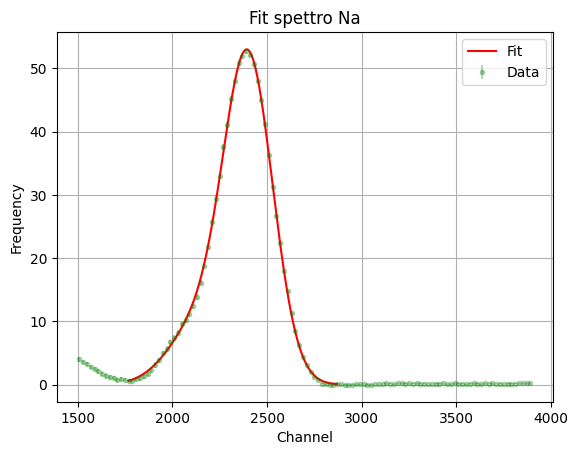

In [124]:
#Fit e plot
ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func)
m = Minuit(ls, A=20000, mu=2300, sigma=150, B=8000, mu2=2200, sigma2=300)
ls.mask = (channel_0 > 1770) & (channel_0 < 2870)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(1770, 2870, 3000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_0[80:200], frequency_0[0][80:200], frequency_0[1][80:200], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

In [114]:
#Calcolo con metodo trapezi
freq_integral = []
channel_integral = []
integral_extremes = [1770, 2870]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

In [116]:
total_amplitude = m.values["A"] + m.values["B"]
total_amplitude_err = np.sqrt(m.errors["A"]**2 + m.errors["B"]**2)

In [117]:
#Stampa risultati
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {total_amplitude:.2f} ± {total_amplitude_err:.2f}')

Area picco con integrale trapezoidale: 20006.22
Area picco con integrale fit: 20101.57 ± 690.62
